In [1]:
import sys
import yt.units as u
import numpy
import numpy as np
import matplotlib.pyplot as plt
import pyximport

from dengo.chemical_network import \
    ChemicalNetwork, \
    reaction_registry, \
    cooling_registry, species_registry
import dengo.primordial_rates, dengo.primordial_cooling
from dengo.chemistry_constants import tiny, kboltz, mh

import os
import h5py
os.environ['HDF5_DIR'] = '/home/kwoksun2/anaconda2/'

/home/kwoksun2/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


 using cli
 using CLI for selections


In [54]:
def Init_values(temperature, density, n_species = 9, cooling=True, size=10):
    """ Create a initial value dictionary,
        for a given temperature, density, number of species
    Args:
        temperature -- in Kelvin
        density     -- in amu / cm**3
        n_species   -- number of species (6/9)
        cooling

    Returns:
        init_values: initial value dictionary with
                     self-consistent energy/ electron density
        primordial : chemical_network classes

    """

    # initialize and setup the network
    dengo.primordial_rates.setup_primordial()
    primordial = ChemicalNetwork()
    primordial.threebody = 4

    if n_species == 9:
        for i in range(22):
            try:
                primordial.add_reaction("k{0:02d}".format(i+1))
            except:
                pass
    else:
        for i in range(6):
            try:
                primordial.add_reaction("k{0:02d}".format(i+1))
            except:
                pass

    # the temperature array required to interpolates the rates
    primordial.init_temperature((1e0, 1e5))

    tiny = 1.0e-20

    # init_array are is in fractional abundances
    init_values = dict()
    density = numpy.array([density])*numpy.ones((size))
    if n_species == 6:
        # 6-species model
        init_values["He_1"]    = density * (1.0 - 0.76)
        init_values["He_2"]    = np.array([tiny])
        init_values["He_3"]    = np.array([tiny])
        init_values["H_1"]     = density *  (0.76)
        init_values['H_2']     = np.array([tiny]) 
    else:
        # 9-species model
        init_values["He_1"]    = density * (1.0 - 0.76) 
        init_values["He_2"]    = density *np.array([tiny])
        init_values["He_3"]    = density *np.array([tiny])
        init_values["H_1"]     = density *  (0.76) /2.0
        init_values['H_2']     = density *np.array([tiny])

        init_values["H_m0"]    = density *np.array([tiny])
        init_values["H2_1"]    = density *  (0.76) /2.0
        init_values["H2_2"]    = density *np.array([tiny])

    # now everything in mass density
    init_values['de'] = primordial.calculate_free_electrons(init_values)
    # one signle value: again mass density
    init_values['density'] = primordial.calculate_total_density(init_values)

    num_den = {}
    for sp in primordial.required_species:
        try:
            num_den[sp.name] = init_values[sp.name]/ sp.weight
        except:
            pass

    # set up initial temperatures values used to define ge
    init_values['T'] = numpy.array([temperature])*numpy.ones((size))
    ge_array = numpy.ones((size))
    init_values['ge'] = ge_array
    
    # calculate gammaH2
    
    for i in range(size):
        
        temperature = init_values['T'][i]
        x = 6100.0/temperature
        expx = numpy.exp(x)
        gammaH2 = 2.0 / (5.0 + 2.0*x*x*expx / (expx - 1 )**2.0 ) + 1

        rs = primordial.required_species
        H2_1_sp = list(rs)[0]
        gammaH2 = primordial.species_gamma(H2_1_sp,name=False, temp=True).subs({'T':temperature})

        new_num_den = {}
        for ele in num_den.keys():
            new_num_den[ele] = num_den[ele][i]
        
        gamma_factor = primordial.gamma_factor().subs(new_num_den).subs({'gammaH2': gammaH2 , 'gamma': 5./3.,'T': temperature })

        ge  = ((temperature *  kboltz) *gamma_factor
                             / (init_values['density'][i] * mh  ))

        
        T = init_values['density']*ge*mh / kboltz / gamma_factor
        init_values['ge'][i] = numpy.float64(ge)
    
    print('--------------------------------------------------')
    if cooling:
        for cooling_action in cooling_registry:
            k = cooling_registry[cooling_action]
            if (k.species).issubset( primordial.required_species ):
                if k.name != "cie_cooling":                    
                    print("adding {} cooling: {}".format(k.name, k.equation))
                    primordial.add_cooling(cooling_action)
    return init_values, primordial

In [55]:
density = 1e10
initial_temperature = 2000.0
final_time = 1e10

final_time_Myr = u.second.in_units('Myr').v * final_time

init, primordial = Init_values(initial_temperature, 
                               density, n_species = 9, 
                               cooling=True,size=128)

Adding reaction: k01 : 1*H_1 + 1*de => 1*H_2 + 2*de
Adding reaction: k02 : 1*H_2 + 1*de => 1*H_1
Adding reaction: k03 : 1*He_1 + 1*de => 1*He_2 + 2*de
Adding reaction: k04 : 1*He_2 + 1*de => 1*He_1
Adding reaction: k05 : 1*He_2 + 1*de => 1*He_3 + 2*de
Adding reaction: k06 : 1*He_3 + 1*de => 1*He_2
Adding reaction: k07 : 1*H_1 + 1*de => 1*H_m0
Adding reaction: k08 : 1*H_m0 + 1*H_1 => 1*H2_1 + 1*de
Adding reaction: k09 : 1*H_1 + 1*H_2 => 1*H2_2
Adding reaction: k10 : 1*H2_2 + 1*H_1 => 1*H2_1 + 1*H_2
Adding reaction: k11 : 1*H2_1 + 1*H_2 => 1*H2_2 + 1*H_1
Adding reaction: k12 : 1*H2_1 + 1*de => 2*H_1 + 1*de
Adding reaction: k13 : 1*H2_1 + 1*H_1 => 3*H_1
Adding reaction: k14 : 1*H_m0 + 1*de => 1*H_1 + 2*de
Adding reaction: k15 : 1*H_m0 + 1*H_1 => 2*H_1 + 1*de
Adding reaction: k16 : 1*H_m0 + 1*H_2 => 2*H_1
Adding reaction: k17 : 1*H_m0 + 1*H_2 => 1*H2_2 + 1*de
Adding reaction: k18 : 1*H2_2 + 1*de => 2*H_1
Adding reaction: k19 : 1*H2_2 + 1*H_m0 => 1*H_1 + 1*H2_1
Adding reaction: k21 : 2*H_1 

In [21]:
import h5py
f = h5py.File('_temp_omp_initial_conditions.h5')

print(f.keys())
print(f['H2_1'])
f.close()

[u'H2_1', u'H2_2', u'H_1', u'H_2', u'H_m0', u'He_1', u'He_2', u'He_3', u'T', u'de', u'density', u'ge']
<HDF5 dataset "H2_1": shape (128,), type "<f8">


In [44]:
solver_name = '_temp_omp'
pyximport.install(setup_args={"include_dirs":np.get_include()},
                  reload_support=True, inplace=True)

primordial.stop_time = 1.0e10
# write the network

primordial.write_solver(solver_name, output_dir = ".",
    solver_template = "openmp-cvdls_n/sundials_CVDls",
    ode_solver_source = "initialize_cvode_solver.C",
    init_values=init,
    input_is_number=False)

# import the pyx module
# sundials_cvdls_run = pyximport.load_module("{}_run".format(solver_name),
#                 "{}_solver_run.pyx".format(solver_name),
#                  build_inplace = True, pyxbuild_dir = "_dengo_temp")

In [45]:
!bash _temp_runfile

In [56]:
%%timeit
!./a.out

Successfully read in rate tables.
Successfully read in cooling rate tables.
Getting dimensionality from ge:
  ncells =  128
Reading I.C. for /H2_1
H2_1[0] = 3.8e+09, atol =>  3.8
Reading I.C. for /H2_2
H2_2[0] = 1e-10, atol =>  3.8
Reading I.C. for /H_1
H_1[0] = 3.8e+09, atol =>  3.8
Reading I.C. for /H_2
H_2[0] = 1e-10, atol =>  3.8
Reading I.C. for /H_m0
H_m0[0] = 1e-10, atol =>  3.8
Reading I.C. for /He_1
He_1[0] = 2.4e+09, atol =>  3.8
Reading I.C. for /He_2
He_2[0] = 1e-10, atol =>  3.8
Reading I.C. for /He_3
He_3[0] = 1e-10, atol =>  3.8
Reading I.C. for /de
de[0] = 1.25e-10, atol =>  3.8
Reading I.C. for /ge
ge[0] = 1.88e+11, atol =>  3.8
BE_chem_solve ERROR: NaN in iteration 0 (cell 1, species 0); dt = 1e+05, atol = 1e-09
BE_chem_solve ERROR: NaN in iteration 0 (cell 1, species 0); dt = 50000, atol = 1e-09
BE_chem_solve ERROR: NaN in iteration 0 (cell 1, species 0); dt = 25000, atol = 1e-09
BE_chem_solve ERROR: NaN in iteration 0 (cell 1, species 0); dt = 12500, atol = 1e-09
BE

Successfully read in rate tables.
Successfully read in cooling rate tables.
Getting dimensionality from ge:
  ncells =  128
Reading I.C. for /H2_1
H2_1[0] = 3.8e+09, atol =>  3.8
Reading I.C. for /H2_2
H2_2[0] = 1e-10, atol =>  3.8
Reading I.C. for /H_1
H_1[0] = 3.8e+09, atol =>  3.8
Reading I.C. for /H_2
H_2[0] = 1e-10, atol =>  3.8
Reading I.C. for /H_m0
H_m0[0] = 1e-10, atol =>  3.8
Reading I.C. for /He_1
He_1[0] = 2.4e+09, atol =>  3.8
Reading I.C. for /He_2
He_2[0] = 1e-10, atol =>  3.8
Reading I.C. for /He_3
He_3[0] = 1e-10, atol =>  3.8
Reading I.C. for /de
de[0] = 1.25e-10, atol =>  3.8
Reading I.C. for /ge
ge[0] = 1.88e+11, atol =>  3.8
BE_chem_solve ERROR: NaN in iteration 0 (cell 1, species 0); dt = 1e+05, atol = 1e-09
BE_chem_solve ERROR: NaN in iteration 0 (cell 1, species 0); dt = 50000, atol = 1e-09
BE_chem_solve ERROR: NaN in iteration 0 (cell 1, species 0); dt = 25000, atol = 1e-09
BE_chem_solve ERROR: NaN in iteration 0 (cell 1, species 0); dt = 12500, atol = 1e-09
BE

1 loop, best of 3: 177 ms per loop


In [37]:
f = h5py.File("_temp_omp_solution.h5")

qh = f['H_2'].value / 1.00794  - f['H_m0'].value/ 1.00794 + f['H2_2'].value/ 2.01588
qhe = f['He_2'].value / 4.002602  + 2.0*f['He_3'].value / 4.002602
qde = f['de'].value
f.close()
numpy.abs( (qh + qhe - qde) / qde)

array([3.74959754e-12, 3.97162336e-12, 3.62067976e-12, 3.62067976e-12,
       3.62067976e-12, 3.62067976e-12, 3.62067976e-12, 3.62067976e-12,
       3.62067976e-12, 3.62067976e-12, 3.62067976e-12, 3.62067976e-12,
       3.62067976e-12, 3.62067976e-12, 3.62067976e-12, 3.62067976e-12,
       3.74959754e-12, 3.97162336e-12, 3.62067976e-12, 3.62067976e-12,
       3.62067976e-12, 3.62067976e-12, 3.62067976e-12, 3.62067976e-12,
       3.62067976e-12, 3.62067976e-12, 3.62067976e-12, 3.62067976e-12,
       3.62067976e-12, 3.62067976e-12, 3.62067976e-12, 3.62067976e-12,
       3.74959754e-12, 3.97162336e-12, 3.62067976e-12, 3.62067976e-12,
       3.62067976e-12, 3.62067976e-12, 3.62067976e-12, 3.62067976e-12,
       3.62067976e-12, 3.62067976e-12, 3.62067976e-12, 3.62067976e-12,
       3.62067976e-12, 3.62067976e-12, 3.62067976e-12, 3.62067976e-12,
       3.74959754e-12, 3.97162336e-12, 3.62067976e-12, 3.62067976e-12,
       3.62067976e-12, 3.62067976e-12, 3.62067976e-12, 3.62067976e-12,
      

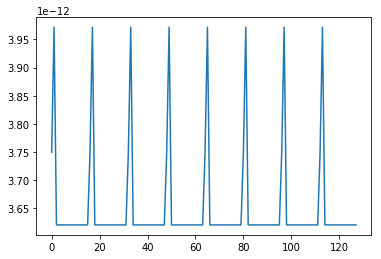

In [38]:
plt.plot(numpy.abs( (qh + qhe - qde) / qde))

In [26]:
f = h5py.File("../../cxxexample/openmp_example/cvdls_9species_solution.h5")

qh = f['H_2'].value / 1.00794  - f['H_m0'].value/ 1.00794 + f['H2_2'].value/ 2.01588
qhe = f['He_2'].value / 4.002602  + 2.0*f['He_3'].value / 4.002602
qde = f['de'].value

f.close()
numpy.abs( (qh + qhe - qde) / qde)

array([1.16750543e-11, 1.33240732e-11, 1.33240732e-11, 1.33240732e-11,
       1.33240732e-11, 1.33240732e-11, 1.33240732e-11, 1.33240732e-11,
       1.33240732e-11, 1.33240732e-11, 1.33240732e-11, 1.33240732e-11,
       1.33240732e-11, 1.33240732e-11, 1.33240732e-11, 1.33240732e-11,
       1.10469831e-11, 1.16751698e-11, 1.16751698e-11, 1.16751698e-11,
       1.16751698e-11, 1.16751698e-11, 1.16751698e-11, 1.16751698e-11,
       1.16751698e-11, 1.16751698e-11, 1.16751698e-11, 1.16751698e-11,
       1.16751698e-11, 1.16751698e-11, 1.16751698e-11, 1.16751698e-11,
       1.10469831e-11, 1.16751698e-11, 1.16751698e-11, 1.16751698e-11,
       1.16751698e-11, 1.16751698e-11, 1.16751698e-11, 1.16751698e-11,
       1.16751698e-11, 1.16751698e-11, 1.16751698e-11, 1.16751698e-11,
       1.16751698e-11, 1.16751698e-11, 1.16751698e-11, 1.16751698e-11,
       1.10469831e-11, 1.16751698e-11, 1.16751698e-11, 1.16751698e-11,
       1.16751698e-11, 1.16751698e-11, 1.16751698e-11, 1.16751698e-11,
      

In [29]:
f = h5py.File("../../cxxexample/openmp_example/cvdls_9species_initial_conditions.h5")

qh = f['H_2'].value / 1.00794  - f['H_m0'].value/ 1.00794 + f['H2_2'].value/ 2.01588
qhe = f['He_2'].value / 4.002602  + 2.0*f['He_3'].value / 4.002602
qde = f['de'].value
print(f['H2_1'].value)
print(f['H_1'].value)
f.close()
numpy.abs( (qh + qhe - qde) / qde)

[3.8e+09 3.8e+09 3.8e+09 3.8e+09 3.8e+09 3.8e+09 3.8e+09 3.8e+09 3.8e+09
 3.8e+09 3.8e+09 3.8e+09 3.8e+09 3.8e+09 3.8e+09 3.8e+09 3.8e+09 3.8e+09
 3.8e+09 3.8e+09 3.8e+09 3.8e+09 3.8e+09 3.8e+09 3.8e+09 3.8e+09 3.8e+09
 3.8e+09 3.8e+09 3.8e+09 3.8e+09 3.8e+09 3.8e+09 3.8e+09 3.8e+09 3.8e+09
 3.8e+09 3.8e+09 3.8e+09 3.8e+09 3.8e+09 3.8e+09 3.8e+09 3.8e+09 3.8e+09
 3.8e+09 3.8e+09 3.8e+09 3.8e+09 3.8e+09 3.8e+09 3.8e+09 3.8e+09 3.8e+09
 3.8e+09 3.8e+09 3.8e+09 3.8e+09 3.8e+09 3.8e+09 3.8e+09 3.8e+09 3.8e+09
 3.8e+09 3.8e+09 3.8e+09 3.8e+09 3.8e+09 3.8e+09 3.8e+09 3.8e+09 3.8e+09
 3.8e+09 3.8e+09 3.8e+09 3.8e+09 3.8e+09 3.8e+09 3.8e+09 3.8e+09 3.8e+09
 3.8e+09 3.8e+09 3.8e+09 3.8e+09 3.8e+09 3.8e+09 3.8e+09 3.8e+09 3.8e+09
 3.8e+09 3.8e+09 3.8e+09 3.8e+09 3.8e+09 3.8e+09 3.8e+09 3.8e+09 3.8e+09
 3.8e+09 3.8e+09 3.8e+09 3.8e+09 3.8e+09 3.8e+09 3.8e+09 3.8e+09 3.8e+09
 3.8e+09 3.8e+09 3.8e+09 3.8e+09 3.8e+09 3.8e+09 3.8e+09 3.8e+09 3.8e+09
 3.8e+09 3.8e+09 3.8e+09 3.8e+09 3.8e+09 3.8e+09 3.

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [ ]:
f = h5py.File("data_struct_solution.h5")

qh = f['H_2'].value / 1.00794  - f['H_m0'].value/ 1.00794 + f['H2_2'].value/ 2.01588
qhe = f['He_2'].value / 4.002602  + 2.0*f['He_3'].value / 4.002602
qde = f['de'].value
f.close()
numpy.abs( (qh + qhe - qde) / qde)

In [ ]:
f = h5py.File("data_struct_solution.h5")

qh = f['H_2'].value / 1.00794  - f['H_m0'].value/ 1.00794 + f['H2_2'].value/ 2.01588
qhe = f['He_2'].value / 4.002602  + 2.0*f['He_3'].value / 4.002602
qde = f['de'].value
f.close()
numpy.abs( (qh + qhe - qde) / qde)

In [ ]:
%%timeit
!./a.out

In [ ]:
162*1e-3 / 10.0

In [ ]:
!bash temp_runfile

In [ ]:
%%timeit
!./a.out

In [5]:
import h5py

In [6]:
f = h5py.File('_temp_omp_tables.h5')

In [7]:
f.keys()

[u'brem_brem',
 u'ceHI_ceHI',
 u'ceHeII_ceHeII',
 u'ceHeI_ceHeI',
 u'ciHI_ciHI',
 u'ciHeII_ciHeII',
 u'ciHeIS_ciHeIS',
 u'ciHeI_ciHeI',
 u'compton_comp_',
 u'dgammaH2_1_dT',
 u'dgammaH2_2_dT',
 u'gammaH2_1',
 u'gammaH2_2',
 u'gammah_gammah',
 u'gloverabel08_gaH2',
 u'gloverabel08_gaHI',
 u'gloverabel08_gaHe',
 u'gloverabel08_gaHp',
 u'gloverabel08_gael',
 u'gloverabel08_gphdl',
 u'gloverabel08_gpldl',
 u'gloverabel08_h2lte',
 u'h2formation_h2mcool',
 u'h2formation_h2mheat',
 u'h2formation_ncrd1',
 u'h2formation_ncrd2',
 u'h2formation_ncrn',
 u'k01',
 u'k02',
 u'k03',
 u'k04',
 u'k05',
 u'k06',
 u'k07',
 u'k08',
 u'k09',
 u'k10',
 u'k11',
 u'k12',
 u'k13',
 u'k14',
 u'k15',
 u'k16',
 u'k17',
 u'k18',
 u'k19',
 u'k21',
 u'k22',
 u'reHII_reHII',
 u'reHeII1_reHeII1',
 u'reHeII2_reHeII2',
 u'reHeIII_reHeIII']

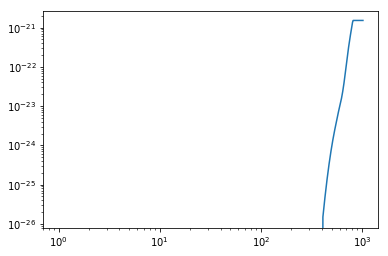

In [16]:
plt.loglog(f[u'gloverabel08_gael'].value)

In [19]:
f.close()

In [49]:
solver_name = '__old'
pyximport.install(setup_args={"include_dirs":np.get_include()},
                  reload_support=True, inplace=True)

primordial.stop_time = 1.0e10
# write the network

primordial.write_solver(solver_name, output_dir = ".",
    solver_template = "be_chem_solve/rates_and_rate_tables",
    ode_solver_source = "BE_chem_solve.C",
    init_values=init,
    input_is_number=False)

# import the pyx module
# sundials_cvdls_run = pyximport.load_module("{}_run".format(solver_name),
#                 "{}_solver_run.pyx".format(solver_name),
#                  build_inplace = True, pyxbuild_dir = "_dengo_temp")

In [51]:
primordial.print_cooling()

TypeError: print_cooling() takes exactly 2 arguments (1 given)